In [10]:
import numpy as np
from scipy import interpolate
from matplotlib import pyplot as plt
import netCDF4 as nc
import ipywidgets as widgets
import json
import datetime

In [11]:
def moment(mu, var, scale):
    x = np.arange(mu.shape[1])
    y = np.arange(mu.shape[0])

    result_x = []
    result_mu = []
    result_var = []

    for i in range(mu.shape[0] - 1):
        for j in range(mu.shape[1] - 1):
            f_subset = mu[i:i+2, j:j+2]
            var_subset = var[i:i+2, j:j+2]

            mu_interpolant = interpolate.interp2d(x[j:j+2], y[i:i+2], f_subset)
            var_interpolant = interpolate.interp2d(x[j:j+2], y[i:i+2], var_subset)

            x_interpolated = np.linspace(x[j], x[j + 1], scale + 1)
            y_interpolated = np.linspace(y[i], y[i + 1], scale + 1)

            s_interpolated = np.transpose(np.meshgrid(x_interpolated, y_interpolated), [1,2,0])
            mu_interpolated = mu_interpolant(x_interpolated, y_interpolated)
            var_interpolated = var_interpolant(x_interpolated, y_interpolated)

            result_x.append(s_interpolated)
            result_mu.append(mu_interpolated)
            result_var.append(var_interpolated)

    return result_x, result_mu, result_var

In [3]:
ds = nc.Dataset('../../../Data/weather/netcdf/day20_200_temp.nc')
print(ds)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Conventions: CF-1.0
    history: 2009-05-20 11:30:32 GMT by mars2netcdf-0.92
    dimensions(sizes): longitude(144), latitude(73), number(9), time(1)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 number(number), int32 time(time), int16 cnrm(time, number, latitude, longitude), int16 crfc(time, number, latitude, longitude), int16 lody(time, number, latitude, longitude), int16 scnr(time, number, latitude, longitude), int16 scwf(time, number, latitude, longitude), int16 smpi(time, number, latitude, longitude), int16 ukmo(time, number, latitude, longitude)
    groups: 


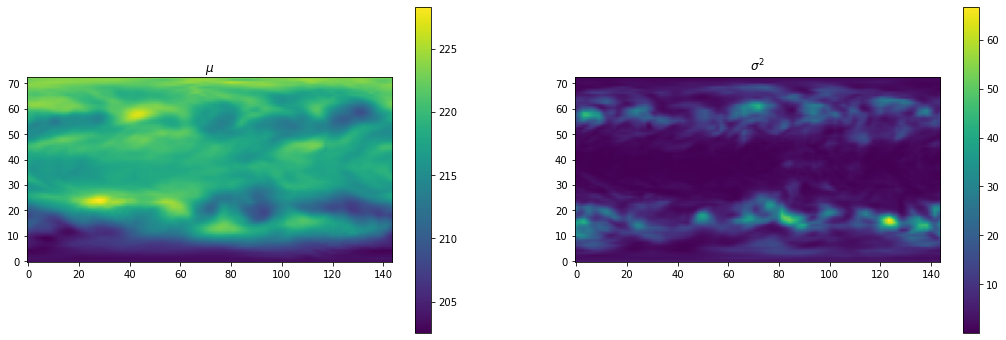

In [45]:
sim = 'ukmo'
samples = ds[sim][0]

mean = np.mean(samples, axis=0)
var = np.var(samples, axis=0)

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.title(r'$\mu$')
plt.imshow(mean, origin='lower')
plt.colorbar()

plt.subplot(1,2,2)
plt.title(r'$\sigma^2$')
plt.imshow(var, origin='lower')
plt.colorbar()

plt.show()

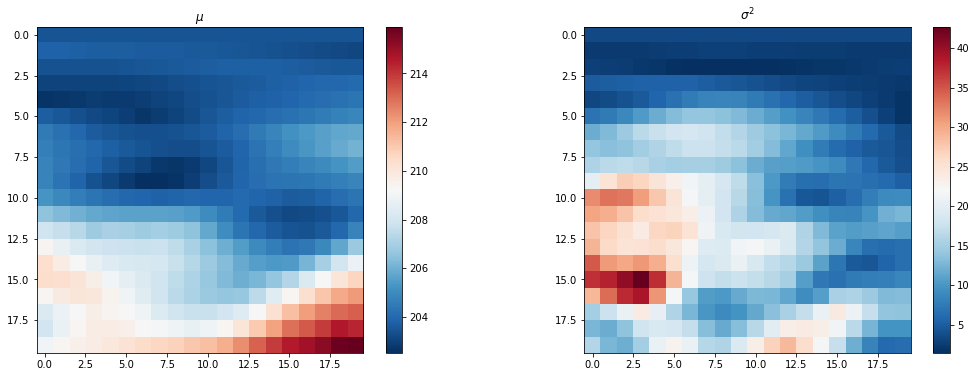

In [46]:
mean_subset = mean[:20,:20]
var_subset = var[:20,:20]

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.title(r'$\mu$')
plt.imshow(mean_subset, cmap='RdBu_r')
plt.colorbar()

plt.subplot(1,2,2)
plt.title(r'$\sigma^2$')
plt.imshow(var_subset, cmap='RdBu_r')
plt.colorbar()

plt.show()

In [47]:
scale = 8
s2, mu2, var2 = moment(mean_subset, var_subset, scale)

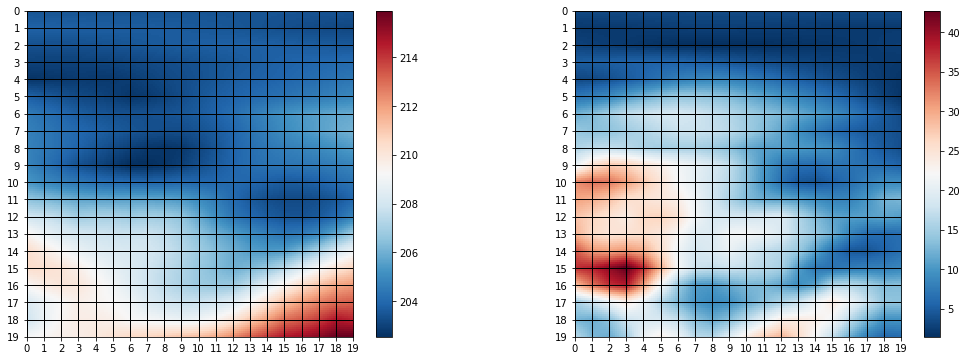

In [48]:
plt.figure(figsize=(18,6))
ax1 = plt.subplot(1,2,1)
for m,s in zip(mu2,s2):
    extent = [
        s[0,0,0] * scale,
        s[0,-1,0] * scale,
        s[-1,0,1] * scale,
        s[0,0,1] * scale
    ]

    img1 = ax1.imshow(m, cmap='RdBu_r', extent=extent, origin='upper', vmin=mean_subset.min(), vmax=mean_subset.max(), interpolation='none')
ax1.set_xticks(np.arange(0, (mean_subset.shape[1] - 1) * scale + 1, scale))
ax1.set_xticklabels(np.arange(mean_subset.shape[1]))
ax1.set_yticks(np.arange(0, (mean_subset.shape[0] - 1) * scale + 1, scale))
ax1.set_yticklabels(np.arange(mean_subset.shape[0]))
ax1.set_xlim(0, (mean_subset.shape[1] - 1) * scale)
ax1.set_ylim(0, (mean_subset.shape[0] - 1) * scale)
ax1.axes.invert_yaxis()
plt.colorbar(img1, ax=ax1)
plt.grid(c='k', lw=1)

ax2 = plt.subplot(1,2,2)
for m,s in zip(var2,s2):
    extent = [
        s[0,0,0] * scale,
        s[0,-1,0] * scale,
        s[-1,0,1] * scale,
        s[0,0,1] * scale
    ]

    img2 = ax2.imshow(m, cmap='RdBu_r', extent=extent, origin='upper', vmin=var_subset.min(), vmax=var_subset.max(), interpolation='none')
ax2.set_xticks(np.arange(0, (mean_subset.shape[1] - 1) * scale + 1, scale))
ax2.set_xticklabels(np.arange(mean_subset.shape[1]))
ax2.set_yticks(np.arange(0, (mean_subset.shape[0] - 1) * scale + 1, scale))
ax2.set_yticklabels(np.arange(mean_subset.shape[0]))
ax2.set_xlim(0, (mean_subset.shape[1] - 1) * scale)
ax2.set_ylim(0, (mean_subset.shape[0] - 1) * scale)
ax2.axes.invert_yaxis()
plt.colorbar(img2, ax=ax2)
plt.grid(c='k', lw=1)

plt.show()

In [49]:
manifest = {
    'files': [
        'moments-day20_200_temp-{:s}-s.npy'.format(sim),
        'moments-day20_200_temp-{:s}-mu.npy'.format(sim),
        'moments-day20_200_temp-{:s}-var.npy'.format(sim)
    ],
    'creator': 'Viktor Leonhardt <leonhardt@cs.uni-kl.de>',
    'date': datetime.datetime.now().__str__(),
    'description': 'Contains the interpolated temperature of the DEMETER project, while only the first 20 x 20 points of the simulation `{:s}` are used to build a random normal field. The moments of the PDF are interpolated and the files contain the sampled points `s`, the mean `mu` and the variance `var`.'.format(sim),
    'parameters': {
        'scale': scale
    },
    'generator': 'uncertainty-vis/Experiments/interpolation/weather/moments.ipynb'
}
with open('../../../Data/weather/interpolation/moments-day20_200_temp-{:s}.manifest'.format(sim), 'w') as f:
    f.write(json.dumps(manifest, indent=2))

np.save('../../../Data/weather/interpolation/moments-day20_200_temp-{:s}-s.npy'.format(sim), s2)
np.save('../../../Data/weather/interpolation/moments-day20_200_temp-{:s}-mu.npy'.format(sim), mu2)
np.save('../../../Data/weather/interpolation/moments-day20_200_temp-{:s}-var.npy'.format(sim), var2)

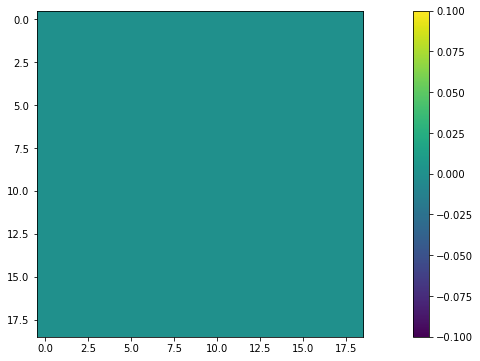

In [17]:
mu_shaped = np.reshape(mu2, (mean_subset.shape[0] - 1, mean_subset.shape[1] - 1, scale+1, scale+1))

difference_map = np.zeros((mean_subset.shape[0] - 1, mean_subset.shape[1] - 1))
for i in range(mu_shaped.shape[0]):
    for j in range(mu_shaped.shape[1]):
        cell_gt = mean_subset[i: i + 2, j: j + 2]

        cell_kriging = np.array([
            [mu_shaped[i,j,0,0], mu_shaped[i,j,0,-1]],
            [mu_shaped[i,j,-1,0], mu_shaped[i,j,-1,-1]]
        ])

        difference_map[i,j] = np.linalg.norm(cell_gt - cell_kriging)

plt.figure(figsize=(18,6))
plt.imshow(difference_map)
plt.colorbar()
plt.show()